<a href="https://colab.research.google.com/github/ashishsaini01/Anomaly_detection_using_autoencoders/blob/main/siamese_network_notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as k
import matplotlib.pyplot as plt
import random

In [53]:
# mounting google drive for easy data reading
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
data = np.load('/content/drive/MyDrive/compress7.npz')
x, g, tx, ty, i, gi, ti = data['x'], data['gx'], data['tx'], data['ty'], data['i'], data['gi'], data['ti']

In [55]:
# from re import X
def create_batch(batch_size=500):
    x_anchors = np.zeros((batch_size, 32, 96, 3))
    x_positives = np.zeros((batch_size, 32, 96, 3))
    x_negatives = np.zeros((batch_size, 32, 96, 3))
    
    for j in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x.shape[0] - 1)
        x_anchor = x[random_index]

        pos_index = random.randint(0, x.shape[0] - 1)

        while pos_index == random_index or i[pos_index] != i[random_index]:
          pos_index = random.randint(0, x.shape[0] - 1)

        x_positive = x[pos_index]  # also for the same pallet block
        
        random_index_neg = random.randint(0, x.shape[0] - 1)

        while random_index_neg == random_index or i[random_index] == i[random_index_neg]:
          random_index_neg = random.randint(0, x.shape[0] - 1)
         
        x_negative = x[random_index_neg]
        
        x_anchors[j] = x_anchor
        x_positives[j] = x_positive
        x_negatives[j] = x_negative
        
    x_anchors = np.expand_dims(x_anchors, axis = 1)
    x_positives = np.expand_dims(x_positives, axis = 1)
    x_negatives = np.expand_dims(x_negatives, axis = 1)

    k = np.concatenate([x_anchors, x_positives, x_negatives], axis = 1)
        
    return k

In [ ]:
examples = create_batch(1)
# plot_triplets(examples)

In [ ]:
examples.shape

(1, 3, 32, 96, 3)

In [ ]:
dim = 10
alpha = 100

In [56]:
# Embedding model
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', strides = 2, padding = 'same', input_shape = (32, 96, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', strides = 2, padding = 'same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(emb_size, activation = 'sigmoid')
])

embedding_model.summary()

# input_layer1 = tf.keras.layers.Input(shape = tri_data.shape[2:])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 48, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 24, 32)         18464     
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 64)                393280    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
Total params: 417,696
Trainable params: 417,696
Non-trainable params: 0
_________________________________________________________________


In [57]:
# siamese network
siamese_input = tf.keras.Input(shape = (3, 32, 96, 3))
input_anchor =  siamese_input[:, 0]                                              #tf.keras.layers.Input(shape=(32, 96, 3))
input_positive = siamese_input[:, 1]                                             #tf.keras.layers.Input(shape=(32, 96, 3))
input_negative = siamese_input[:, 2]                                             #tf.keras.layers.Input(shape=(32, 96, 3))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

embedding_anchor = k.expand_dims(embedding_anchor, 1)
embedding_negative = k.expand_dims(embedding_negative, 1)
embedding_positive = k.expand_dims(embedding_positive, 1)


output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1) 

model = tf.keras.models.Model(siamese_input, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 32, 96,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 32, 96, 3)   0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 32, 96, 3)   0           ['input_1[0][0]']                
 icingOpLambda)                                                                               

In [58]:
alpha = 0.05
pos = k.mean((embedding_anchor - embedding_positive)**2, axis = 1)
neg = k.mean((embedding_anchor - embedding_negative)**2, axis = 1)
loss = k.mean(k.relu(pos - neg + alpha)) 

In [59]:
batch_size=5000
x_train = create_batch(batch_size)
# x_train = np.array(x_train)
x_train.shape

(5000, 3, 32, 96, 3)

In [60]:
# batch_size = 2048
epochs = 25
# steps_per_epoch = 25


model.add_loss(loss)
model.compile(optimizer='adam')

callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min') # for early stopping

history = model.fit(
    x_train,
    epochs=epochs, verbose=True, callbacks = [callback], validation_split = 0.2)

Epoch 1/25
125/125 [==============================] - 24s 178ms/step - loss: 0.0333 - val_loss: 0.0325
Epoch 2/25
125/125 [==============================] - 19s 154ms/step - loss: 0.0291 - val_loss: 0.0298
Epoch 3/25
125/125 [==============================] - 20s 160ms/step - loss: 0.0269 - val_loss: 0.0277
Epoch 4/25
125/125 [==============================] - 20s 160ms/step - loss: 0.0247 - val_loss: 0.0265
Epoch 5/25
125/125 [==============================] - 19s 154ms/step - loss: 0.0236 - val_loss: 0.0242
Epoch 6/25
125/125 [==============================] - 19s 155ms/step - loss: 0.0224 - val_loss: 0.0240
Epoch 7/25
125/125 [==============================] - 19s 154ms/step - loss: 0.0214 - val_loss: 0.0229
Epoch 8/25
125/125 [==============================] - 19s 155ms/step - loss: 0.0209 - val_loss: 0.0224
Epoch 9/25
125/125 [==============================] - 19s 155ms/step - loss: 0.0194 - val_loss: 0.0215
Epoch 10/25
125/125 [==============================] - 19s 155ms/step - l

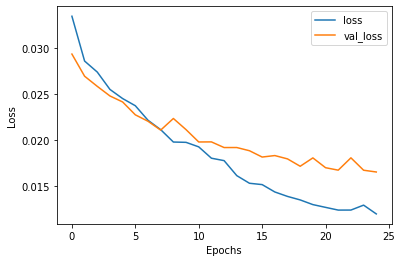

In [ ]:
# ploting 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
x_predict = embedding_model.predict(x)
g_predict = embedding_model.predict(g)
t_predict = embedding_model.predict(tx)

In [ ]:
# np.savez_compressed("/content/drive/MyDrive/compress_predictions.npz", x_pre = x_predict, g_pre = g_predict, t_pre = t_predict)

In [4]:
predict_data = np.load('/content/drive/MyDrive/compress_predictions.npz')
x_pre, g_pre, t_pre = predict_data['x_pre'], predict_data['g_pre'], predict_data['t_pre']

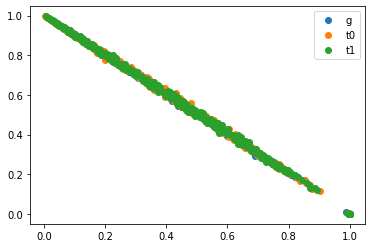

In [31]:
g_pre1 = g_pre[:, :2]
t_pre1 = t_pre[:, :2]

t0 = t_pre1[ty == 0]
t1 = t_pre1[ty == 1]

plt.plot(g_pre[:,0],  g_pre[:,1], "o", label = "g")
plt.plot(t0[:,0], t0[:,1], "o", label = "t0")
plt.plot(t1[:,0], t1[:,1], "o", label = "t1")
plt.legend()

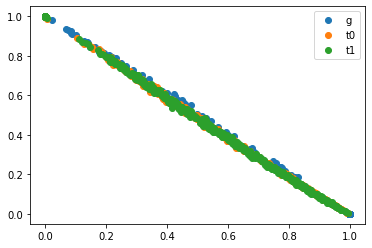

In [32]:
g_pre1 = g_pre[:, 3:5]
t_pre1 = t_pre[:, 3:5]

t0 = t_pre1[ty == 0]
t1 = t_pre1[ty == 1]

plt.plot(g_pre[:,0],g_pre[:,1],"o",label="g")
plt.plot(t0[:,0],t0[:,1],"o",label="t0")
plt.plot(t1[:,0],t1[:,1],"o",label="t1")
plt.legend()

In [29]:
g_pre1 = g_pre[:, 8:10]
t_pre1 = t_pre[:, 8:10]

t0 = t_pre1[ty == 0]
t1 = t_pre1[ty == 1]

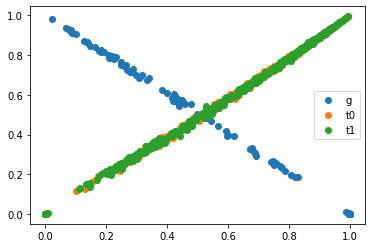

In [30]:
plt.plot(g_pre[:,0],g_pre[:,1],"o",label="g")
plt.plot(t0[:,0],t0[:,1],"o",label="t0")
plt.plot(t1[:,0],t1[:,1],"o",label="t1")
plt.legend()

In [45]:
# from sklearn.metrics import roc_auc_score
# roc_auc_score(ty, t_pre)
g[2].shape

(32, 96, 3)